## MNIST Digits Generation using DCGAN


*   In this Notebook we'll build a DCGAN Model to produce MNIST digits
*   Objective - Generating new MNIST images to augment the size of the dataset.



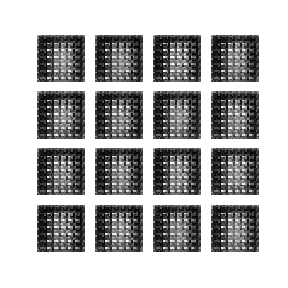

## Pipeline
Steps Involved


1. Importing Libraries
2. Data Loading and Visualization
3. Data Preprocessing
4. Model Building
5. Model Training
6. Generating a GIF of Generated Images



### Importing Libraries


Important Libraries and their versions
*   numpy - 1.19.2
*   tensorflow - 2.4.1
*   matplotlib - 3.3.2
*   skimage - 0.17.2

In [7]:
#Importing necessary Libraries.
import tensorflow as tf
import matplotlib.pyplot as plt
import glob # to find certain directories
import imageio
from IPython import display
from skimage.transform import resize
import numpy as np
import os # to access the folders and files
from tensorflow.keras.utils import plot_model

### Data Loading and Visualization
1. Data Loading
2. Data Visualization

#### Load the MNIST Data

In [8]:
# Loading the MNIST Dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


#### Visualize a sample image

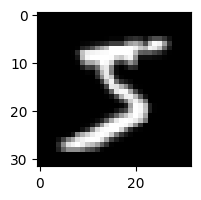

In [14]:
plt.figure(figsize=(2, 2))
plt.imshow(train_images[0], cmap='gray')
# plt.axis('off')
plt.show()

### Data Preprocessing


1.   Normalization of Images
2.   Resize Images
1.   Reshape Images
2.   Shuffle Data





#### Declare Buffer Size, Batch Size and Dimensions of Noise


In [11]:
BUFFER_SIZE = 60000
BATCH_SIZE = 2048
NOISE_DIM = 100

#### Normalization of Images between [-1, 1]
Pixel Normalization with zero center

In [12]:
train_dataset = (train_images/127.5)-1.0
# Normalize the images to [-1.0, 1.0]

#### Resize Images to size (32, 32)


In [13]:
train_images = np.zeros((BUFFER_SIZE, 32, 32))
for index, img in enumerate(train_dataset):
    train_images[index, :, :] = resize(img, (32, 32))

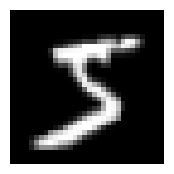

In [15]:
plt.figure(figsize=(2, 2))
plt.imshow(train_images[0], cmap='gray')
plt.axis('off')
plt.show()

#### Reshape Image to add channel dimension

In [16]:
train_images = train_images.reshape(train_images.shape[0], 32, 32, 1).astype('float32')

#### Shuffle the data and store in Batches
shuffle - Randomly shuffles the elements of this dataset.

batch - Combines consecutive elements of this dataset into batches.

In [17]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE, seed=42).batch(BATCH_SIZE)

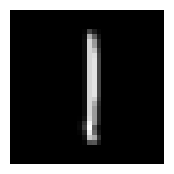

In [20]:
sample = next(iter(train_dataset))
plt.figure(figsize=(2, 2))
plt.imshow(sample[0].numpy()[:, :, 0], cmap='gray')
plt.axis('off')
plt.show()

### Model Building


1.   Generator Model Building
2.   Discriminator Model Building



#### Generator Model Building using Transposed Convolutional Layers

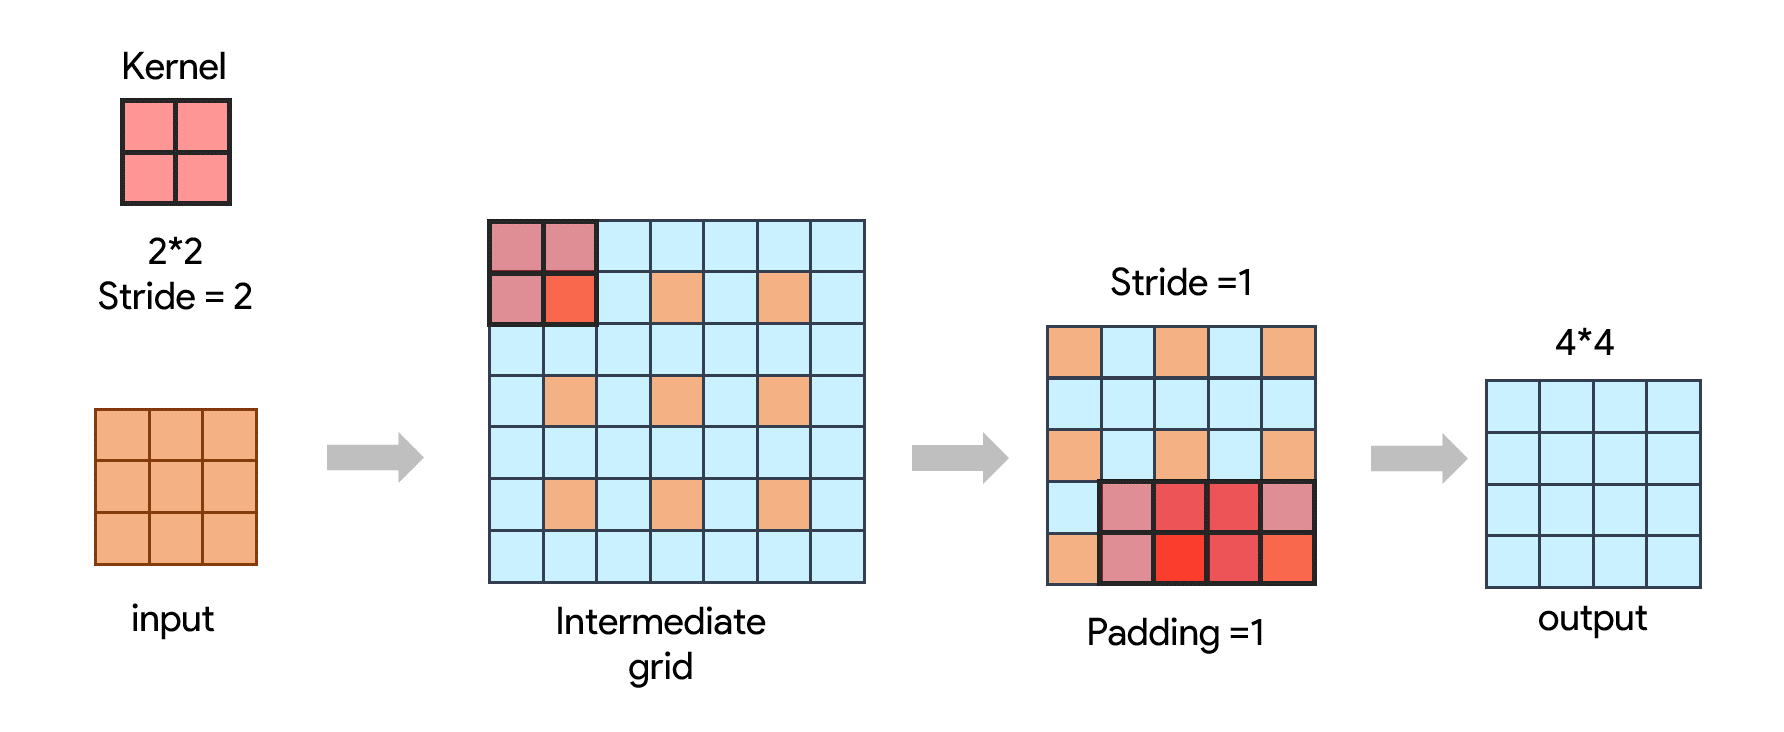

In [21]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(4*4*128, use_bias=False, input_shape=(NOISE_DIM,))) # 1-D
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((4, 4, 128)))

    model.add(tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), use_bias=False, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), use_bias=False, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), use_bias=False, padding='same', activation='tanh'))

    return model

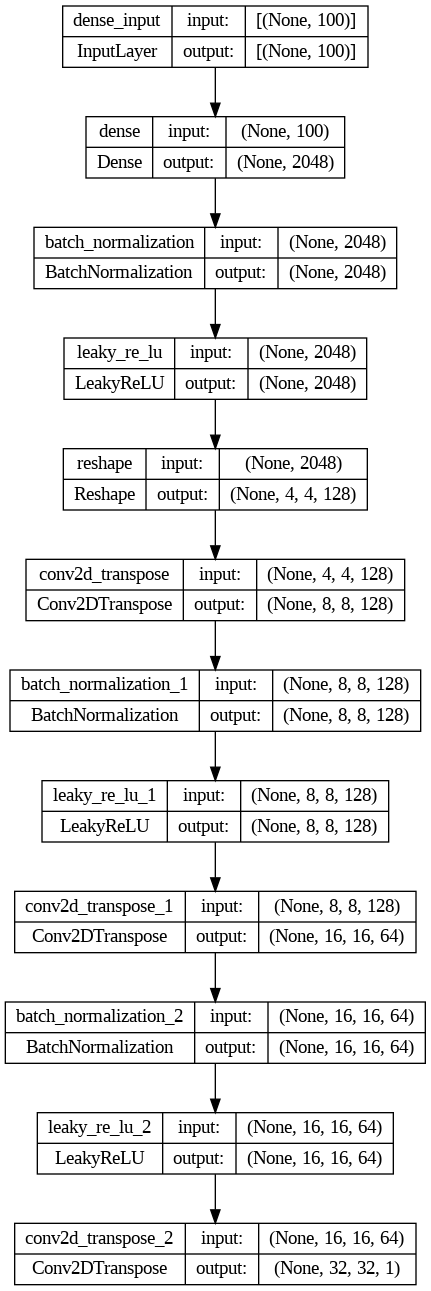

In [22]:
generator = make_generator_model()
plot_model(generator, show_shapes=True, show_layer_names=True)

#### Generate Image through a Raw model
Untrained model would generate noisy sample.

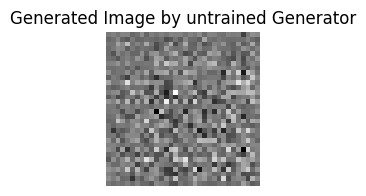

In [24]:
constant_noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator(constant_noise, training=False)

plt.figure(figsize=(2, 2))
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.title('Generated Image by untrained Generator')
plt.axis('off')
plt.show()

#### Discriminator Model Building using Convolutional Layers

In [25]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1), use_bias=False,
                                     input_shape=[32, 32, 1]))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(1, (10, 10), strides=(1, 1)))

    model.add(tf.keras.layers.Flatten())

    return model

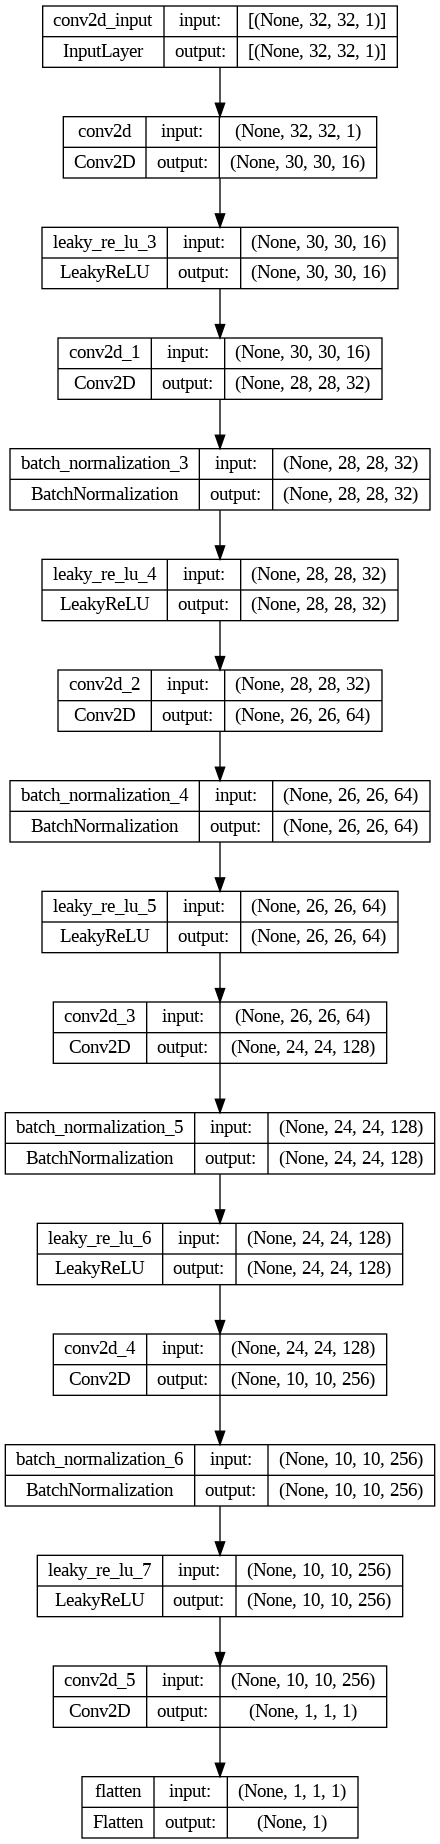

In [26]:
discriminator = make_discriminator_model()
plot_model(discriminator, show_shapes=True, show_layer_names=True)

In [27]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00183347]], shape=(1, 1), dtype=float32)


### Model Training


1.   Loss Type
2.   Discriminator Loss
3.   Generator Loss
4.   Optimizer
5.   Checkpoint Initialization
6.   Training Flow



#### Declare Binary Cross Entropy Loss since we'll calculate Loss on Discriminator which is a classifier

In [28]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Calculate Discriminator Loss
It consists of two types of losses

1.    Loss on Real Data
2.    Loss on Fake Data


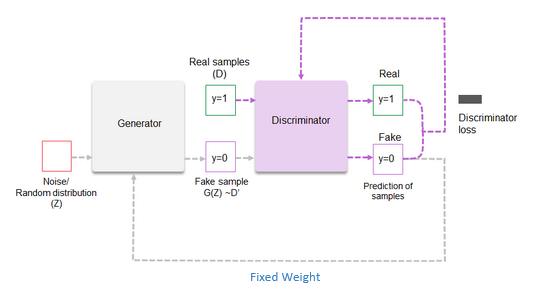

In [29]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### Generator Loss
It has only one type of loss - Discriminator Loss on Generated data

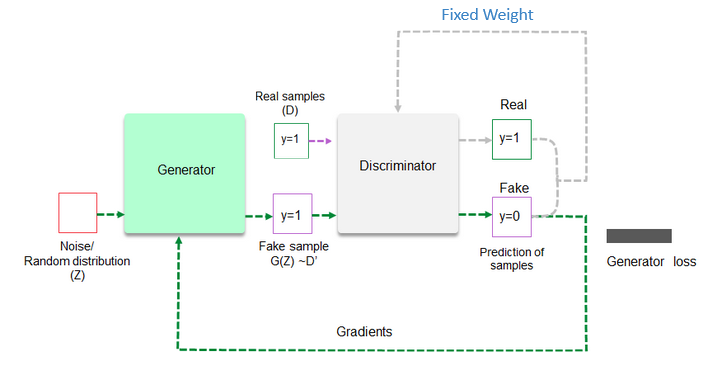

In [30]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### Using Adam Optimizer

In [31]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

We will train our model for 250 epochs

In [38]:
EPOCHS = 24

#### Checkpoint Initialization
Initialize checkpoints to save models

In [33]:
# Directory to keep Generated Images each epoch
if not os.path.isdir('generated_images'):
    os.mkdir('generated_images')

# Directory to save checkpoints
checkpoint_dir = './training_checkpoints'
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

#### Training FLow
Below Function performs one Flow of Batch Training

In [34]:
@tf.function
def train_step(images):
    # Take Noise
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # To track the gradients for calculation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate Fake Image from Noise
        generated_images = generator(noise, training=True)

        # Check Discriminator's output for Real and Fake Image
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Generator's loss on Fake and Discriminator's loss on both Real and Fake
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate the Gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply Gradients in the optimizer
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#### Train the DCGAN Model for several Epochs
Loop training function for number of epochs and also show the output at each step. <p>
Note how Generator is getting better at producing realistic images epoch by epoch

In [35]:
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, NOISE_DIM])

In [ ]:
for epoch in range(1, EPOCHS+1):
    for image_batch in train_dataset:
        train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)

    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = generator(seed, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

### Generating a GIF of Generated Images
After Training let's use our Generators to produce various images from training.
Notice the Quality of results we are getting.

In [39]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

<ipython-input-39-19d8e987e05b>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-39-19d8e987e05b>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [40]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-1cpqw519
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-1cpqw519
  Resolved https://github.com/tensorflow/docs to commit 377cb52f6d1df66b21a4d03b42694fb9dbd93ba7
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.9.4.19335-py3-none-any.whl size=184104 sha256=1d866cd72cbe206649ff166062d338bdc23b4766ec4c462d9d46046d3c65929c
  Stored in directory: /tmp/pip-ephem-wheel-cache-3t78fnhx/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs



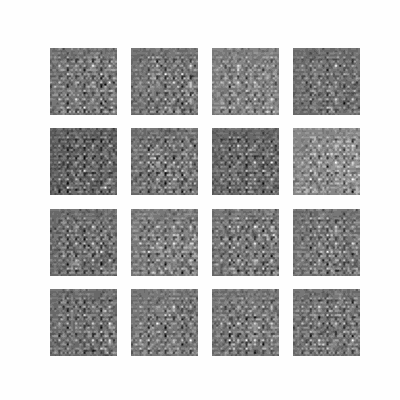

In [41]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)